In [1]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import pandas as pd
import matplotlib.pyplot as plt
from flask import Flask, jsonify


In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurements', 'station']

In [6]:
# pd.read_sql('measurements',con=engine,index_col=None, 
#             coerce_float=True, params=None, parse_dates=None, columns=None, chunksize=None)

# pd.read_sql('station',con=engine,index_col=None, 
#             coerce_float=True, params=None, parse_dates=None, columns=None, chunksize=None)

In [7]:
Measurements = Base.classes.measurements

In [8]:
Station = Base.classes.station

In [9]:
session = Session(engine)

In [10]:
results = (session
           .query(Measurements.date, Measurements.prcp)
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <='2017-12-31')
           .filter(Measurements.date >='2017-01-01')
           .group_by(Measurements.date)
           .all())

In [11]:
date = [result[0] for result in results]
prcp = [float(result[1]) for result in results]


<h2><b>Precipitation Analysis</b>

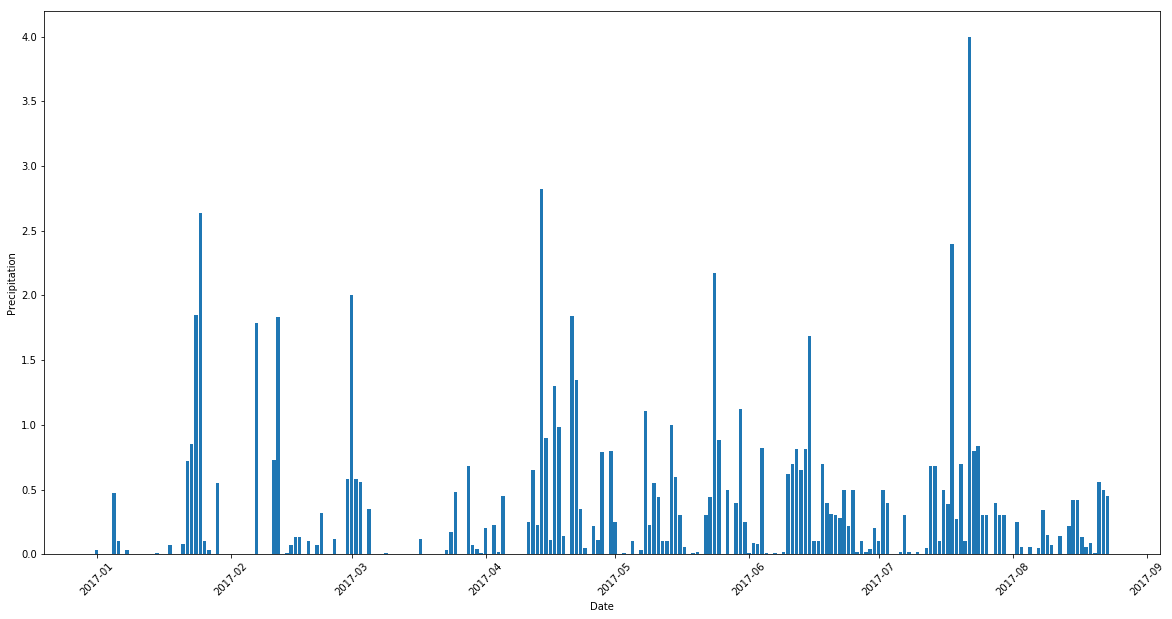

In [12]:
#date = range(1, len(prcp)+1)
plt.figure(figsize=(20,10))

plt.bar(date, prcp)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.xticks(rotation=45)

plt.show()

<b>Descriptive Statistics for Precipitation Data</b>

In [13]:
pr_df = pd.DataFrame(results)
pr_df.describe()

,prcp
count,235.000000
mean,0.305660
std,0.540142
min,0.000000
25%,0.000000
50%,0.080000
75%,0.410000
max,4.000000


<h2>Station Analysis</h2>

In [14]:
# Design a query to calculate the total number of stations.

# Design a query to find the most active stations.

    # List the stations and observation counts in descending order

    # Which station has the highest number of observations?

# Design a query to retrieve the last 12 months of temperature observation data (tobs).

# Filter by the station with the highest number of observations.

# Plot the results as a histogram with bins=12.

Number of Stations

In [15]:
number_of_stations = (session
           .query(Station.station)
           .group_by(Station.station)
           .count())
number_of_stations

9

Active Stations 

In [16]:
active_stations = (session
           .query(Station.station, func.count(Measurements.id))
           .filter(Station.station == Measurements.station)
           .group_by(Station.station)
           .order_by(func.count(Measurements.id).desc())
           .all())
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

Station with the Highest Activity

In [17]:
most_active_station = active_stations[0][0]
most_active_station

'USC00519281'

TOBS from last 12 months


In [18]:
tobs = (session
           .query(Measurements.date, Measurements.tobs)
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <='2017-12-31')
           .filter(Measurements.date >='2017-01-01')
           .group_by(Measurements.date)
           .all())
tobs_df = pd.DataFrame(tobs)
tobs_df.head()


,date,tobs
0,2017-08-23,76
1,2017-08-22,76
2,2017-08-21,76
3,2017-08-20,80
4,2017-08-19,71


TOBS for most active station

In [19]:
most_active_tobs = (session
           .query(Measurements.date, Measurements.tobs)
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <='2017-12-31')
           .filter(Measurements.date >='2017-01-01')
           .group_by(Measurements.date)
           .filter(Measurements.station == most_active_station)
           .all())
most_active_tobs_df = pd.DataFrame(most_active_tobs)
most_active_tobs_df.head()

,date,tobs
0,2017-08-18,79
1,2017-08-17,76
2,2017-08-16,76
3,2017-08-15,77
4,2017-08-14,77


In [20]:
hist_data = most_active_tobs_df.groupby(["tobs"]).count()
hist_data.reset_index( inplace=True)
hist_data.head()

,tobs,date
0,59,3
1,60,2
2,61,1
3,62,5
4,63,3


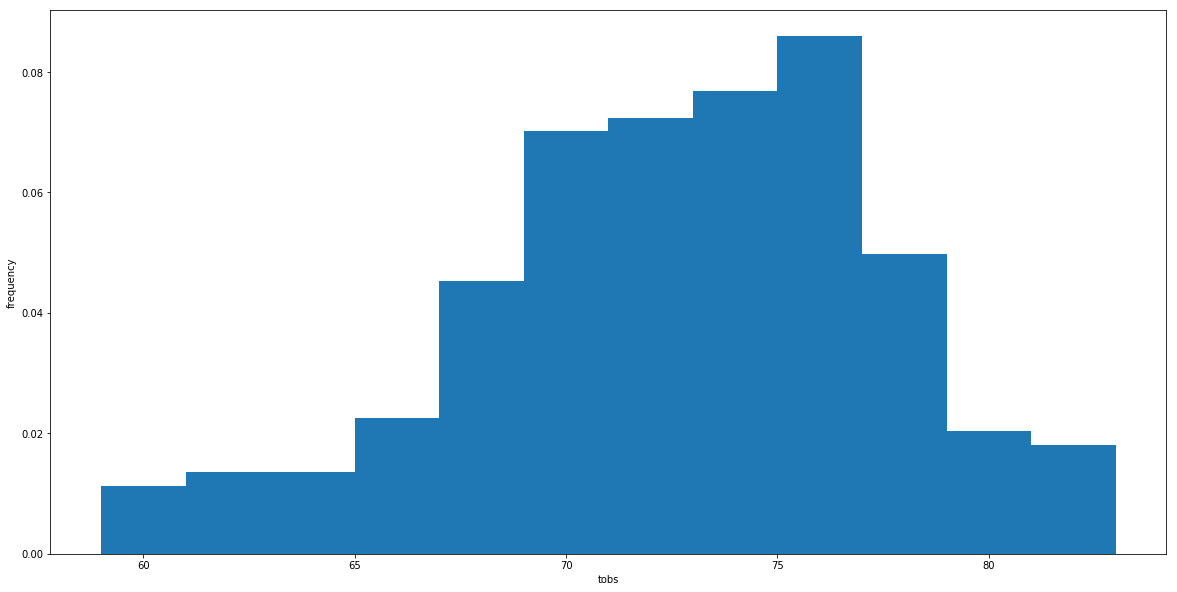

In [21]:
plt.figure(figsize=(20,10))

plt.hist(most_active_tobs_df['tobs'],12 , normed=1, histtype='bar')
plt.xlabel("tobs")
plt.ylabel("frequency")

plt.show()

<h2>Temperature Analysis



In [22]:
# Write a function called calc_temps that will accept a start date
# and end date in the format %Y-%m-%d and return the minimum, average,
# and maximum temperatures for that range of dates.

In [23]:
def temp_analysis(start_date, end_date):
    temp = (session
           .query(func.min(Measurements.prcp), func.max(Measurements.prcp), func.avg(Measurements.prcp)  )
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <=end_date)
           .filter(Measurements.date >=start_date)
           .all())
    
    return temp
#(min_temp, max_temp, avg_temp)

start_date = '2017-01-01'
end_date = '2017-01-10'

a = temp_analysis(start_date, end_date)      

#print("Min temp: ", min_temp)
# print("Max temp: ", max_temp)
# print("Avg temp: ", avg_temp)
a

[(0.0, 0.59, 0.04745098039215686)]

In [24]:

min_temp = a[0][0]
max_temp = a[0][1]
avg_temp = a[0][2]

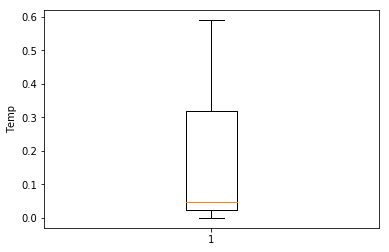

In [25]:
plt.boxplot(a)
plt.ylabel("Temp")
plt.show()

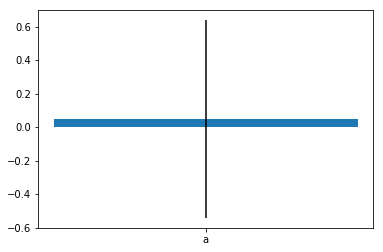

In [26]:
yerr = (max_temp - min_temp)
plt.bar('a',avg_temp,yerr=yerr)
plt.show()

In [27]:
app = Flask(__name__)


In [29]:
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/names<br/>"
        f"/api/v1.0/passengers"
    )



In [30]:
@app.route("/api/v1.0/precipitation")
def prec():
    """Query for the dates and temperature observations from the last year"""
    # Query all passengers
    prcp_results =(session
           .query(Measurements.date, Measurements.prcp)
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <='2017-12-31')
           .filter(Measurements.date >='2017-01-01')
           .group_by(Measurements.date)
           .all())
        # Convert list of tuples into normal list
    prcp_res = [row[0] for row in prcp_results]

    return jsonify(prcp_res)


In [31]:
@app.route("/api/v1.0/tobs")
def tob():
    """Query for the dates and temperature observations from the last year"""
    # Query all passengers
    results = (session
           .query(Measurements.date, Measurements.tobs)
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <='2017-12-31')
           .filter(Measurements.date >='2017-01-01')
           .group_by(Measurements.date)
           .all())
    
    # Convert list of tuples into normal list
    all_results = [row[0] for row in results]

    return jsonify(all_results)


In [36]:
@app.route("/api/v1.0/stations")
def stat():
    all_stations = (session
           .query(Station.station)
           .group_by(Station.station)
           .all())
    all_stations_ = [row[0] for row in all_stations]

    return jsonify(all_stations_)


AssertionError: View function mapping is overwriting an existing endpoint function: stat

In [42]:
@app.route("/api/v1.0/<start>")
def starting():
    temp_start = (session
           .query(func.min(Measurements.prcp), func.max(Measurements.prcp), func.avg(Measurements.prcp)  )
           .order_by(Measurements.date.desc())
           .filter(Measurements.date >=start_date)
           .all())
    temp_start_res = [row[0] for row in temp_start]

    return jsonify(temp_start_res)


In [44]:
@app.route("/api/v1.0/<start>/<end>")
def ending():
    temp_end = (session
           .query(func.min(Measurements.prcp), func.max(Measurements.prcp), func.avg(Measurements.prcp)  )
           .order_by(Measurements.date.desc())
           .filter(Measurements.date <=end_date)
           .filter(Measurements.date >=start_date)
           .all())
    temp_end_res = [row[0] for row in temp_end]

    return jsonify(temp_end_res)


  


AssertionError: View function mapping is overwriting an existing endpoint function: ending

In [35]:

if __name__ == '__main__':
    app.run(debug=True)


OSError: [Errno 48] Address already in use